###Load Data


In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import os
import codecs
import json
import csv

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

In [2]:
# http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_json.html
# Convert a JSON string to pandas object

X = pd.read_json('./pizza_request_dataset.json')
print ("type(X)", type(X))
print

# set random seed
np.random.seed(0)

# randomly assign 70% to train_data, and 30% to dev_data
msk = np.random.rand(len(X)) <= 0.7
train_data = X[msk]
dev_data = X[~msk]

# create output dataframe Y of train_labels
train_labels = train_data[["requester_received_pizza"]]

# delete train_labels from input dataframe of train_data
del train_data["requester_received_pizza"]

# create output dataframe of dev_labels
dev_labels = dev_data[["requester_received_pizza"]]

# delete dev_labels from input dataframe of dev_data
del dev_data["requester_received_pizza"]

# print (labels, shapes, and feature names
print ("train_labels" )
print ("----------")
print (list(train_labels))
print (train_labels.shape), "/n"
print ("train_data" )
print ("----------")
print (list(train_data))
print (train_data.shape), "/n"


print ("dev_labels") 
print ("----------")
print (list(dev_labels))
print (dev_labels.shape), "/n"

print ("dev_data")
print ("----------")
print (list(dev_data))
print (dev_data.shape), "/n"

# print (percent of train_data and dev_data whose posts led to receipt of pizza
print ("train labels")
print ("----------")
print (np.mean(train_labels)), "/n"
print ("dev labels")
print ("----------")
print (np.mean(dev_labels))

type(X) <class 'pandas.core.frame.DataFrame'>
train_labels
----------
['requester_received_pizza']
(3975, 1)
train_data
----------
['giver_username_if_known', 'in_test_set', 'number_of_downvotes_of_request_at_retrieval', 'number_of_upvotes_of_request_at_retrieval', 'post_was_edited', 'request_id', 'request_number_of_comments_at_retrieval', 'request_text', 'request_text_edit_aware', 'request_title', 'requester_account_age_in_days_at_request', 'requester_account_age_in_days_at_retrieval', 'requester_days_since_first_post_on_raop_at_request', 'requester_days_since_first_post_on_raop_at_retrieval', 'requester_number_of_comments_at_request', 'requester_number_of_comments_at_retrieval', 'requester_number_of_comments_in_raop_at_request', 'requester_number_of_comments_in_raop_at_retrieval', 'requester_number_of_posts_at_request', 'requester_number_of_posts_at_retrieval', 'requester_number_of_posts_on_raop_at_request', 'requester_number_of_posts_on_raop_at_retrieval', 'requester_number_of_subre

##Text Part


#####0a.Extract text and tile for train and dev

In [4]:
train_text=train_data['request_text'].as_matrix()
train_title=train_data['request_title'].as_matrix()

dev_text=dev_data['request_text'].as_matrix()
dev_title=dev_data['request_title'].as_matrix()


#####0b.Helper Method

In [5]:
from sklearn.metrics import roc_curve, auc

def model_output(pred_probas, F_Score, preds):

    print ("Logistic regression on numeric data: F-Score = %0.4f: "%(F_Score) ) #Sum up Squared Weights
    accuracy = np.where(preds==np.ravel(dev_labels), 1, 0).sum() / float(len(dev_labels))
    print ("Accuracy = %0.4f" % (accuracy))
    print ('accuracy_score: %f' %metrics.precision_score(dev_labels, preds))
    print ('recall_score: %f' %metrics.recall_score(dev_labels, preds))
    print ("roc_auc_score:", metrics.roc_auc_score(dev_labels, preds))

    #Create ROC Curve

    fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
    roc_auc = metrics.auc(fpr,tpr)
    plt.plot(fpr,tpr,label='area = %.2f' %roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.legend(loc='lower right')
    print('auc: %.2f' %roc_auc)
    
    plt.show()

In [6]:
def train_log(train,dev):
    
    model_LG_func = LogisticRegression(penalty ='l2',C=13)
    model_LG_func.fit(train, np.ravel(train_labels))
    
    preds_train = model_LG_func.predict(train)
    F_Score_train = metrics.f1_score(train_labels, preds_train, average='binary')
    pred_probas_train = model_LG_func.predict_proba(train)

    preds = model_LG_func.predict(dev)
    F_Score = metrics.f1_score(dev_labels, preds, average='binary')
    pred_probas = model_LG_func.predict_proba(dev)

    #Call to display outputs
    model_output(pred_probas, F_Score, preds)
    fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
    roc_auc_dev = metrics.auc(fpr,tpr)
    fpr,tpr,_ = roc_curve(train_labels, pred_probas_train[:,1])
    roc_auc_train = metrics.auc(fpr,tpr)
    
    print(roc_auc_train,roc_auc_dev)

In [7]:

def first_preprocessor(s):
    #convert to lowercase
    s=s.lower()
    s=re.sub("[,.!?:;/~*]"," ",s)
    #remove duplicated 0s and 1s
    s=re.sub("[0-9]*","",s)
    #remove number longer than 5 digit
    s=re.sub("[0-9]{5,}","",s)
    #remove stem end with 'ly'
    s=re.sub("ly\s"," ",s)
    #remove plural form
    s=re.sub("s\s"," ",s)
    s=re.sub("s\Z"," ",s)
    #remove _ as the end of word
    s=re.sub("[_]+"," ",s)
    #remove _ as start of the word
    s=re.sub("\s[_]+"," ",s)
    #remove stem end with 'ness'
    s=re.sub("ness\s"," ",s)
    s=re.sub("ing\s"," ",s)
    #remove words that are too short
    s=re.sub("\s[0-9a-z]{1,2}\s"," ",s)
    s=re.sub("\s[0-9a-z]{1,2}\Z"," ",s)

    return s

#####1.Convert Text to word features based on TF-IDF

In [8]:
def empty_preprocessor(s):
    return s


vectorizer_process = TfidfVectorizer(preprocessor =first_preprocessor,analyzer='word',stop_words='english',ngram_range=(1, 8) )
train_matrix_process_text= vectorizer_process.fit_transform(train_text)
dev_matrix_process_text = vectorizer_process.transform(dev_text)

# train_log(train_matrix_process_text,dev_matrix_process_text)

# model_LG = LogisticRegression(penalty ='l2',C=1)
# model_LG.fit(train_matrix_process_text, np.ravel(train_labels))


#####2.Feature ranking with recursive feature elimination & cross-validated selection of the best number of features.

Optimal number of features : 31664


C:\Users\lgu\AppData\Local\Continuum\Anaconda\envs\mpl33\lib\site-packages\sklearn\utils\validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


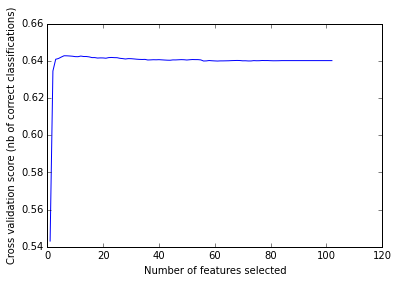

In [9]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

# Build a LogisticRegression Classifier with L2 Regularization

logistic  = LogisticRegression(penalty ='l2',C=1)

rfecv = RFECV(estimator=logistic , step=0.01, cv=5,scoring='roc_auc')
rfecv.fit(train_matrix_process_text, train_labels)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Logistic regression on numeric data: F-Score = 0.0303: 
Accuracy = 0.7358
accuracy_score: 0.304348
recall_score: 0.015945
roc_auc_score: 0.501608305562
auc: 0.64


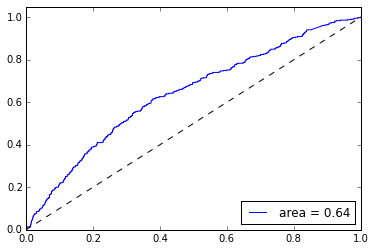

0.639567397517


In [10]:
cv_features=train_matrix_process_text[:,rfecv.support_]
cv_features_dev= dev_matrix_process_text[:,rfecv.support_]

logistic = LogisticRegression(penalty ='l2',C=1)#C from the above test
logistic.fit(cv_features, train_labels.values.flatten())


preds = logistic.predict(cv_features_dev)
pred_probas = logistic.predict_proba(cv_features_dev)
F_Score = metrics.f1_score(dev_labels, preds, average='binary')


# Call to display outputs
model_output(pred_probas, F_Score, preds)
fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
roc_auc = metrics.auc(fpr,tpr)
print(roc_auc)



#####3.Add Extra Features

###### a)Add Narratives based on Title

In [42]:
desire = re.compile(r'(friend|party|birthday|boyfriend|girlfriend|date|drinks|drunk|wasted|invite|invited|celebrate|celebrating|game|games|movie|beer|crave|craving|gf)', re.IGNORECASE)
family = re.compile(r'(husband|wife|family|parent|parents|mother|father|mom|mum|son|dad|daughter|firstborn|pregnancy )', re.IGNORECASE)
job = re.compile(r'(job|unemployment|employment|hire|hired|fired|interview|work)', re.IGNORECASE)
money = re.compile(r'(money|bill|bills|rent|bank|account|paycheck|due|broke|bills|deposit|cash|dollar|dollars|bucks|paid|payed|buy|check|spent|financial|poor|loan|\
credit|budget|day|now|time|week|until|last|month|tonight|today|next|night|when|tomorrow|first|after|while|before|long|hour|Friday|ago|still|due|past|soon|current|years|never|till|yesterday|morning|evening)', re.IGNORECASE)
student = re.compile(r'(college|student|university|finals|study|studying|class|semester|school|roommate|project|tuition|dorm)', re.IGNORECASE)
mood = re.compile(r'(thank|thanks|thankful|appreciate|grateful|gratitude|advance)', re.IGNORECASE) 
holiday = re.compile(r'(anniversary|chirstmas)', re.IGNORECASE)   


In [17]:
def myfunc(a,b):
    if len(a)==0:
        return 0 
    else:
        return len(b.findall(a))/float(len(a))


In [44]:
narrative_all=np.zeros(shape=(len(train_text),6),dtype=int)
narrative_all_dev=np.zeros(shape=(len(dev_text),6),dtype=int)

for index,i in enumerate([family,desire,holiday,mood,job,money]):
    
    vfunc = np.vectorize(myfunc)
    narrative=vfunc(train_title+train_text,i)
    med=np.median(narrative)
    narrative_all[:,index]=np.where(narrative>0,1,0)
    
    narrative_dev=vfunc(dev_title+dev_text,i)
    med=np.median(narrative_dev)
    narrative_all_dev[:,index]=np.where(narrative_dev>0,1,0)


Logistic regression on numeric data: F-Score = 0.0388: 
Accuracy = 0.7370
accuracy_score: 0.360000
recall_score: 0.020501
roc_auc_score: 0.50388620989
auc: 0.65


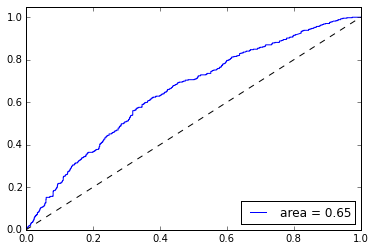

0.651320260301


In [45]:
train_narrative=np.concatenate((cv_features.toarray(), narrative_all), axis=1)
dev_narrative=np.concatenate((cv_features_dev.toarray(), narrative_all_dev), axis=1)


logistic = LogisticRegression(penalty ='l2',C=1)#C from the above test
logistic.fit(train_narrative, train_labels.values.flatten())


preds = logistic.predict(dev_narrative)
pred_probas = logistic.predict_proba(dev_narrative)
F_Score = metrics.f1_score(dev_labels, preds, average='binary')


# Call to display outputs
model_output(pred_probas, F_Score, preds)
fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
roc_auc = metrics.auc(fpr,tpr)
print(roc_auc)


###### b)Add exclamation mark based on Title [I decide to remove this part.... since it is not imptoving auc]

In [53]:
exclmarks = re.compile(r'(!)', re.M)
 
excl_marks=np.zeros(shape=(len(train_text),1),dtype=int)
excl_marks_dev=np.zeros(shape=(len(dev_text),1),dtype=int)

for index,i in enumerate([exclmarks]):
    
    vfunc = np.vectorize(myfunc)
    narrative=vfunc(train_title,i)
    narrative_dev=vfunc(dev_title,i)
    excl_marks[:,index]=np.where(narrative>0,1,0)
    excl_marks_dev[:,index]=np.where(narrative_dev>0,1,0)

(3975, 31671)
Logistic regression on numeric data: F-Score = 0.0389: 
Accuracy = 0.7376
accuracy_score: 0.375000
recall_score: 0.020501
roc_auc_score: 0.504283982364
auc: 0.65


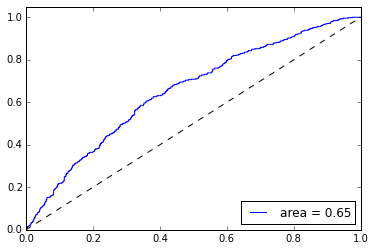

0.650952388719


In [54]:
train_narrative_excl=np.concatenate((train_narrative, excl_marks), axis=1)
dev_narrative_excl=np.concatenate((dev_narrative, excl_marks_dev), axis=1)
print(train_narrative_excl.shape)


logistic = LogisticRegression(penalty ='l2',C=1)#C from the above test
logistic.fit(train_narrative_excl, train_labels.values.flatten())


preds = logistic.predict(dev_narrative_excl)
pred_probas = logistic.predict_proba(dev_narrative_excl)
F_Score = metrics.f1_score(dev_labels, preds, average='binary')


# Call to display outputs
model_output(pred_probas, F_Score, preds)
fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
roc_auc = metrics.auc(fpr,tpr)
print(roc_auc)


###### c)Add capitalized word on Title

In [73]:
train_caps = train_data['request_title'].apply(lambda x: np.where(sum(1 for c in re.split('\W+',x) if c.isupper() and len(c) > 5) > 0, 1,0)).as_matrix()
dev_caps = dev_data['request_title'].apply(lambda x: np.where(sum(1 for c in re.split('\W+',x) if c.isupper() and len(c) > 5) > 0, 1,0)).as_matrix()
train_caps=train_caps.reshape(len(train_caps),1) 
dev_caps=dev_caps.reshape(len(dev_caps),1) 


(3975, 31671)
Logistic regression on numeric data: F-Score = 0.0390: 
Accuracy = 0.7382
accuracy_score: 0.391304
recall_score: 0.020501
roc_auc_score: 0.504681754838
auc: 0.65


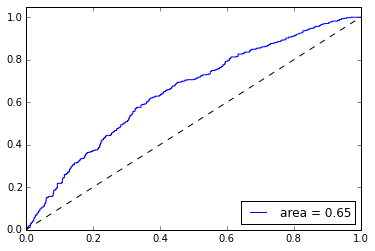

0.651535003072


In [75]:
train_narrative_excl_cap=np.concatenate((train_narrative, train_caps), axis=1)
dev_narrative_excl_cap=np.concatenate((dev_narrative, dev_caps), axis=1)
print(train_narrative_excl_cap.shape)


logistic = LogisticRegression(penalty ='l2',C=1)#C from the above test
logistic.fit(train_narrative_excl_cap, train_labels.values.flatten())


preds = logistic.predict(dev_narrative_excl_cap)
pred_probas = logistic.predict_proba(dev_narrative_excl_cap)
F_Score = metrics.f1_score(dev_labels, preds, average='binary')


# Call to display outputs
model_output(pred_probas, F_Score, preds)
fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
roc_auc = metrics.auc(fpr,tpr)
print(roc_auc)


#####4.L1 Regularization

In [78]:

for c in np.arange(0.1,20,0.5):
    
    Logistic_L1 = LogisticRegression(penalty ='l1',C=c)#C from the above test
    Logistic_L1.fit(train_narrative_excl_cap, np.ravel(train_labels))

    #Update the new index
    index=[]
    for i,z in enumerate(np.sum(np.abs(Logistic_L1.coef_),axis=0) ):
        if z!=0:
            index.append(i)

    train_features_final=train_narrative_excl_cap[:,index]
    dev_features_final=dev_narrative_excl_cap[:,index]

    Logistic_L2 = LogisticRegression(penalty ='l2',C=1)#C from the above test
    Logistic_L2.fit(train_features_final, np.ravel(train_labels))

    preds = Logistic_L2.predict(dev_features_final)
    pred_probas = Logistic_L2.predict_proba(dev_features_final)
    F_Score = metrics.f1_score(np.ravel(dev_labels), preds, average='binary')


    #Call to display outputs
#     model_output(pred_probas, F_Score, preds) #Please input pred_probas, F_Score, and prediction(preds)
    fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
    roc_auc = metrics.auc(fpr,tpr)
    print ('C=%.2f, auc=%.5f, %i features selected. ' %(c,roc_auc,len(index)))


C=0.10, auc=0.59958, 4 features selected. 
C=0.60, auc=0.61101, 8 features selected. 
C=1.10, auc=0.61928, 12 features selected. 
C=1.60, auc=0.63726, 27 features selected. 
C=2.10, auc=0.64328, 50 features selected. 
C=2.60, auc=0.64563, 81 features selected. 
C=3.10, auc=0.64606, 116 features selected. 
C=3.60, auc=0.64874, 174 features selected. 
C=4.10, auc=0.64937, 224 features selected. 
C=4.60, auc=0.64941, 297 features selected. 
C=5.10, auc=0.65169, 365 features selected. 
C=5.60, auc=0.64945, 416 features selected. 
C=6.10, auc=0.65062, 478 features selected. 
C=6.60, auc=0.64832, 570 features selected. 
C=7.10, auc=0.64807, 623 features selected. 
C=7.60, auc=0.64816, 714 features selected. 
C=8.10, auc=0.64790, 805 features selected. 
C=8.60, auc=0.64814, 1005 features selected. 
C=9.10, auc=0.64783, 1174 features selected. 
C=9.60, auc=0.64802, 1456 features selected. 
C=10.10, auc=0.64674, 1565 features selected. 
C=10.60, auc=0.64724, 1625 features selected. 
C=11.10, au

Logistic regression on numeric data: F-Score = 0.0089: 
Accuracy = 0.7388
accuracy_score: 0.250000
recall_score: 0.004556
roc_auc_score: 0.499891269483
auc: 0.65


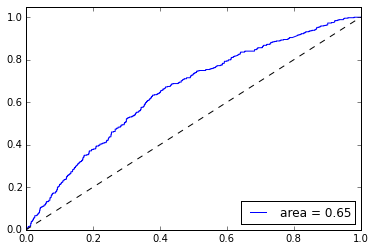

C=8, auc=0.65166, 369 features selected. 


In [79]:
Logistic_L1 = LogisticRegression(penalty ='l1',C=5.1)#C from the above test
Logistic_L1.fit(train_narrative_excl_cap, np.ravel(train_labels))

#Update the new index
index=[]
for i,z in enumerate(np.sum(np.abs(Logistic_L1.coef_),axis=0) ):
    if z!=0:
        index.append(i)

train_features_final=train_narrative_excl_cap[:,index]
dev_features_final=dev_narrative_excl_cap[:,index]

Logistic_L2 = LogisticRegression(penalty ='l2',C=1)#C from the above test
Logistic_L2.fit(train_features_final, np.ravel(train_labels))

preds = Logistic_L2.predict(dev_features_final)
pred_probas = Logistic_L2.predict_proba(dev_features_final)
F_Score = metrics.f1_score(np.ravel(dev_labels), preds, average='binary')


#Call to display outputs
model_output(pred_probas, F_Score, preds) #Please input pred_probas, F_Score, and prediction(preds)
fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
roc_auc = metrics.auc(fpr,tpr)
print ('C=%i, auc=%.5f, %i features selected. ' %(8,roc_auc,len(index)))

#####5.Hyper-Parameter Tuning and compare models

{'C': 37}
0.734910308508


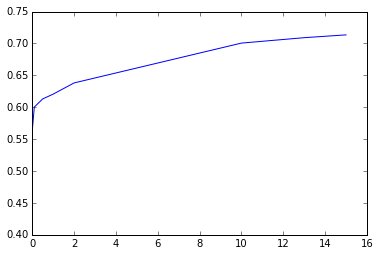

In [88]:
from sklearn.grid_search import GridSearchCV
classifier = LogisticRegression(penalty ='l2')
Cs = {'C': [ 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0, 13.0, 15.0, 17.0, 20.0, 23.0, 27, 30, 33, 37]}

clf = GridSearchCV(classifier, Cs,scoring ='roc_auc',cv=6)
clf.fit(train_features_final, np.ravel(train_labels))
print(clf.best_params_)
print(clf.best_score_)

score=[]
para=[]
for i in range(10):
    score.append(clf.grid_scores_[i][1])
    para.append(clf.grid_scores_[i][0]['C'])

    
plt.plot(para,score)
# plt.plot(para,score)



Logistic regression on numeric data: F-Score = 0.4087: 
Accuracy = 0.6144
accuracy_score: 0.338831
recall_score: 0.514806
roc_auc_score: 0.581985527968
auc: 0.63


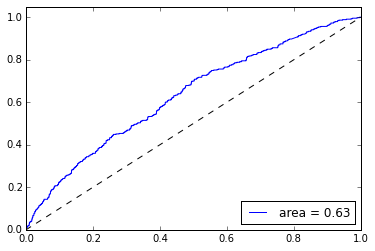

0.631452476609


In [95]:
C_best=clf.best_params_['C']


Logistic_L2 = LogisticRegression(penalty ='l2',C=C_best)#C from the above test
Logistic_L2.fit(train_features_final, np.ravel(train_labels))

preds = Logistic_L2.predict(dev_features_final)
pred_probas = Logistic_L2.predict_proba(dev_features_final)
F_Score = metrics.f1_score(np.ravel(dev_labels), preds, average='binary')


#Call to display outputs
model_output(pred_probas, F_Score, preds) #Please input pred_probas, F_Score, and prediction(preds)
fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
roc_auc = metrics.auc(fpr,tpr)
print (roc_auc)

Le: This is the part I'm not quite understand, that the auc is lower

In [82]:
from sklearn.svm import SVC

tuned_parameters = [
                    {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]


# Build a SVM Classifier with linear kernel
classifier = SVC()

clf = GridSearchCV(classifier,tuned_parameters,scoring ='roc_auc',cv=6)
clf.fit(train_features_final, np.ravel(train_labels))
print(clf.best_params_)
print(clf.best_score_)



{'kernel': 'linear', 'C': 1000}
0.747352328214


Logistic regression on numeric data: F-Score = 0.0000: 
Accuracy = 0.7412
accuracy_score: 0.000000
recall_score: 0.000000
roc_auc_score: 0.5
auc: 0.61


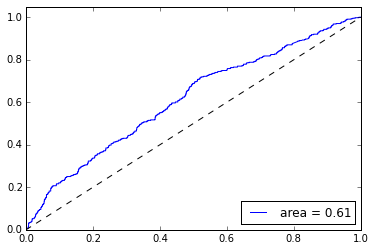

0.612444570089


In [87]:

svc= SVC(C=1000 , kernel='rbf',gamma= 0.0001,probability=True)#C from the above test
# svc= SVC(C=1000 , kernel='linear',probability=True) ##this is too bad

svc.fit(train_features_final, np.ravel(train_labels))

preds = svc.predict(dev_features_final)
pred_probas = svc.predict_proba(dev_features_final)
F_Score = metrics.f1_score(np.ravel(dev_labels), preds, average='binary')


#Call to display outputs
model_output(pred_probas, F_Score, preds) #Please input pred_probas, F_Score, and prediction(preds)
fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
roc_auc = metrics.auc(fpr,tpr)
print (roc_auc)


#Below parts are all my progressions, please ignore.
#I will clean up, re-organize and make a new version that we can share

In [303]:
X = pd.read_json('./test.json')
test_data=X
test_text=test_data['request_text_edit_aware'].as_matrix()
test_title=test_data['request_title'].as_matrix()


In [304]:
from itertools import compress
a=list(compress(vectorizer_process.get_feature_names(), rfecv.support_))


In [306]:
vectorizer_process_conv = TfidfVectorizer(preprocessor =first_preprocessor,analyzer='word',stop_words='english',ngram_range=(1, 8) ,vocabulary=a)
test_matrix_process_text= vectorizer_process_conv.fit_transform(test_text)
# dev_matrix_process_text_cov = vectorizer_process_conv.transform(test_text)

In [307]:
test_matrix_process_text.shape

(1631, 31664)

In [ ]:
narrative_all_conv=np.zeros(shape=(len(train_text),5),dtype=int)
narrative_all_conv=np.zeros(shape=(len(dev_text),5),dtype=int)

for index,i in enumerate([family,money,holiday,job,mood]):
    
    vfunc = np.vectorize(myfunc)
    narrative=vfunc(train_title,i)
    narrative_dev=vfunc(dev_title,i)
    med=np.median(narrative)
    narrative_all[:,index]=np.where(narrative>med,1,0)


(3975, 473)
Logistic regression on numeric data: F-Score = 0.0633: 
Accuracy = 0.7382
accuracy_score: 0.428571
recall_score: 0.034169
roc_auc_score: 0.509128832977
auc: 0.63


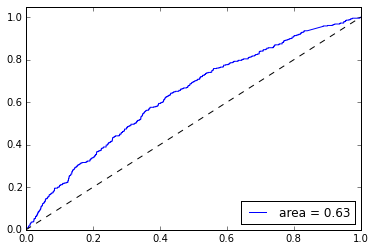

0.632213590227


In [107]:
train_narrative=np.concatenate((cv_features.toarray(), narrative_all), axis=1)
dev_narrative=np.concatenate((cv_features_dev.toarray(), narrative_all_dev), axis=1)

print(train_narrative.shape)
# train_log(train_matrix_process_text,dev_matrix_process_text)
# train_log(train_narrative,dev_narrative)


# vectorizer_process = CountVectorizer(analyzer='word',stop_words='english',preprocessor = empty_preprocessor)
# word_matrix_process= vectorizer_process.fit_transform(train_all_balance)
# dev_matrix_process = vectorizer_process.transform(dev_all)

a=train_narrative
b=dev_narrative

model_LG_L1 = LogisticRegression(penalty ='l1',C=1)#C from the above test
model_LG_L1.fit(a, np.ravel(train_labels))

#Update the new index
index=[]
for i,z in enumerate(np.sum(np.abs(model_LG_L1.coef_),axis=0) ):
    if z!=0:
        index.append(i)
            
model_LG = LogisticRegression(penalty ='l2',C=1)#C from the above test
model_LG.fit(a[:,index], np.ravel(train_labels))

preds = model_LG.predict(b[:,index])
F_Score = metrics.f1_score(np.ravel(dev_labels), preds, average='binary')
pred_probas = model_LG.predict_proba(b[:,index])

#Call to display outputs
model_output(pred_probas, F_Score, preds) #Please input pred_probas, F_Score, and prediction(preds)
fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
roc_auc = metrics.auc(fpr,tpr)
print (roc_auc)

In [ ]:
from sklearn.grid_search import GridSearchCV
classifier = svc = SVC(kernel="linear")
Cs = {'C': [ 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0, 13.0, 15.0]}

clf = GridSearchCV(classifier, Cs,scoring ='roc_auc',cv=6)
clf.fit(train_features_final, np.ravel(train_labels))
print(clf.best_params_)
print(clf.best_score_)

###take a look at the top cofficient words


Optimal number of features : 4068


C:\Users\lgu\AppData\Local\Continuum\Anaconda\envs\mpl33\lib\site-packages\sklearn\utils\validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


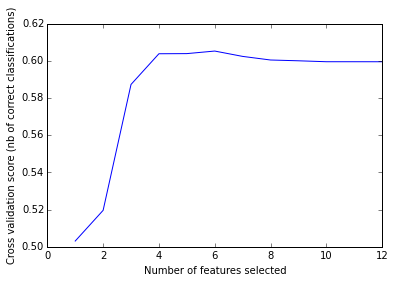

In [9]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

# Build a SVM Classifier with linear kernel
svc = SVC(kernel="linear")

rfecv = RFECV(estimator=svc, step=0.1, cv=5,scoring='roc_auc')
rfecv.fit(train_matrix_process_text, train_labels)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Logistic regression on numeric data: F-Score = 0.0596: 
Accuracy = 0.7394
accuracy_score: 0.451613
recall_score: 0.031891
roc_auc_score: 0.509183198236
auc: 0.60


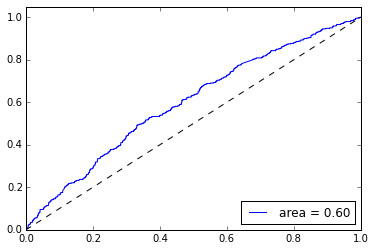

0.596861674849


In [12]:
cv_features=train_matrix_process_text[:,rfecv.support_]
cv_features_dev= dev_matrix_process_text[:,rfecv.support_]

from sklearn.svm import SVC

svr = SVC(kernel="linear",probability=True)
svr.fit(cv_features, train_labels.values.flatten())


preds = svr.predict(cv_features_dev)
F_Score = metrics.f1_score(dev_labels, preds, average='binary')
pred_probas = svr.predict_proba(cv_features_dev)

# Call to display outputs
model_output(pred_probas, F_Score, preds)
fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
roc_auc = metrics.auc(fpr,tpr)
print(roc_auc)



In [140]:
print(model_LG.coef_.shape)
# print( abs(model_LG.coef_ [0]))
# print(len(vectorizer_process.vocabulary_))
# print(vectorizer_process.vocabulary_)

model_LG = LogisticRegression(penalty ='l2',C=1)
model_LG.fit(train_matrix_process_text, np.ravel(train_labels))

index_good=np.argsort((model_LG.coef_ [0]))[-200:]

df = pd.DataFrame({'Feature': np.array(vectorizer_process.get_feature_names())[index_good], 'coef': np.array(model_LG.coef_ [0])[index_good]})
print(df)

index_bad=np.argsort((model_LG.coef_ [0]))[:200]

df = pd.DataFrame({'Feature': np.array(vectorizer_process.get_feature_names())[index_bad], 'coef': np.array(model_LG.coef_ [0])[index_bad]})
print(df)


# a=np.concatenate((np.array(vectorizer_process.get_feature_names())[index],np.array(model_LG.coef_ [0])[index]), axis=0)
# a= np.array(vectorizer_process.get_feature_names())[index]+np.array(model_LG.coef_ [0])[index]
# print(a)

(1, 10164)
          Feature      coef
0           booze  0.515605
1      unexpected  0.516884
2          paying  0.517429
3         drained  0.517980
4              wa  0.519384
5           cheer  0.520825
6         katzmcn  0.522486
7         managed  0.524853
8        received  0.528355
9            skip  0.529663
10          touch  0.531015
11       carolina  0.533128
12       giftcard  0.534986
13           papa  0.535260
14             gt  0.535905
15            cny  0.536643
16      wildernes  0.536643
17          forum  0.537660
18        january  0.538437
19          super  0.539903
20          cover  0.540653
21       absolute  0.542615
22           blow  0.543957
23        immense  0.545204
24         biggie  0.546672
25   biochemistry  0.548862
26          payed  0.550278
27         bought  0.551330
28          teach  0.551402
29       portland  0.552184
..            ...       ...
170        sunday  0.998053
171          come  1.009468
172         month  1.017403
173      

##Try to find the best number of words to include in the model

In [141]:
def empty_preprocessor(s):
    return s

def train_tf_idf(dicts):
    
    vectorizer_process_limit = TfidfVectorizer(preprocessor =first_preprocessor,analyzer='word',stop_words='english',vocabulary=dicts )
    train_matrix_process_text= vectorizer_process_limit.fit_transform(train_text)
    dev_matrix_process_text = vectorizer_process_limit.transform(dev_text)


    model_LG_limit = LogisticRegression(penalty ='l2',C=13)
    model_LG_limit.fit(train_matrix_process_text, np.ravel(train_labels))

    # print('f1_score: %f' %metrics.f1_score(dev_labels,model_LG.predict(dev_matrix_process_text),average='binary'))
    # print('precision_score: %f' %metrics.precision_score(dev_labels,model_LG.predict(dev_matrix_process_text)))
    # print('recall_score: %f' %metrics.recall_score(dev_labels,model_LG.predict(dev_matrix_process_text)))
    # print('accuracy_score: %f' %metrics.accuracy_score(dev_labels,model_LG.predict(dev_matrix_process_text)))

    preds = model_LG_limit.predict(dev_matrix_process_text)
    F_Score = metrics.f1_score(dev_labels, preds, average='binary')
    pred_probas = model_LG_limit.predict_proba(dev_matrix_process_text)

    #Call to display outputs
#     model_output(pred_probas, F_Score, preds)
    fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
    roc_auc = metrics.auc(fpr,tpr)
    return roc_auc

In [142]:
auc=[]
idx=[]
for i in range(100,4000,40):
    index_good=np.argsort((model_LG.coef_ [0]))[-i:]
    index_bad=np.argsort((model_LG.coef_ [0]))[:i]
    dicts=[]
    dicts=list(np.array(vectorizer_process.get_feature_names())[index_good])+list(np.array(vectorizer_process.get_feature_names())[index_bad])
    auc.append(train_tf_idf(dicts))
    idx.append(i)


 
    


[52 65 53 64 67 48 47 51 61 43 66 62 46 68 50 55 63 59 56 44 75 45 54 60 57
 74 76 69 77 49 41 42 72 58 40 78 71 73 70 79 39 80 29 28 30 38 81 16 31 82
 37 15 83 84 36 14  9 20 27 85 86 26 87 90 19 33 89 32 17 88 35 91 18 92 13
 24 22 11 34 12 21 93 25 23 95 10  8 97 94 96  7  5  1  6  2  4  3  0]
100
0.593394983536


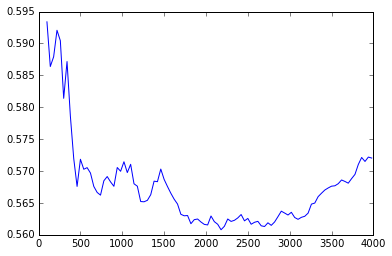

In [144]:
plt.plot(idx,auc)
# plt.show()
print(np.argsort(auc))
print(idx[0])
print(auc[0])


####given the best number of words to include is 220, i picked the top 220 words from each side

In [23]:
for i in [220]:
    index_good=np.argsort((model_LG.coef_ [0]))[-i:]
    index_bad=np.argsort((model_LG.coef_ [0]))[:i]
    dicts=[]
    dicts=list(np.array(vectorizer_process.get_feature_names())[index_good])+list(np.array(vectorizer_process.get_feature_names())[index_bad])
    vectorizer_process_limit = TfidfVectorizer(preprocessor =first_preprocessor,analyzer='word',stop_words='english',vocabulary=dicts )
    train_matrix_process_text= vectorizer_process_limit.fit_transform(train_text)
    dev_matrix_process_text = vectorizer_process_limit.transform(dev_text)

Logistic regression on numeric data: F-Score = 0.2538: 
Accuracy = 0.7123
accuracy_score: 0.386047
recall_score: 0.189066
roc_auc_score: 0.542027063026
auc: 0.62


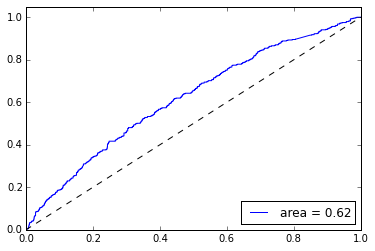

0.616356150432


In [24]:
np.random.seed(0)

# vectorizer_process = CountVectorizer(analyzer='word',stop_words='english',preprocessor = empty_preprocessor)
# word_matrix_process= vectorizer_process.fit_transform(train_all_balance)
# dev_matrix_process = vectorizer_process.transform(dev_all)

a=train_matrix_process_text
b=dev_matrix_process_text

model_LG_L1 = LogisticRegression(penalty ='l1',C=1)#C from the above test
model_LG_L1.fit(a, np.ravel(train_labels))

#Update the new index
index=[]
for i,z in enumerate(np.sum(np.abs(model_LG_L1.coef_),axis=0) ):
    if z!=0:
        index.append(i)
            
model_LG = LogisticRegression(penalty ='l2',C=13)#C from the above test
model_LG.fit(a[:,index], np.ravel(train_labels))

preds = model_LG.predict(b[:,index])
F_Score = metrics.f1_score(np.ravel(dev_labels), preds, average='binary')
pred_probas = model_LG.predict_proba(b[:,index])

#Call to display outputs
model_output(pred_probas, F_Score, preds) #Please input pred_probas, F_Score, and prediction(preds)
fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
roc_auc = metrics.auc(fpr,tpr)
print (roc_auc)



In [ ]:
train_matrix_process_text.shape

In [80]:

# Recursive Feature Elimination
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
# load the iris datasets

# create a base classifier used to evaluate a subset of attributes
model = LogisticRegression(penalty ='l2',C=13)
# create the RFE model and select 3 attributes
rfe = RFE(model)
rfe = rfe.fit(train_matrix_process_text, train_labels)
# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)

[False False False ..., False False False]
[2532 9121 4684 ..., 2475 4992  500]


C:\Users\lgu\AppData\Local\Continuum\Anaconda\envs\mpl33\lib\site-packages\sklearn\utils\validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [151]:
sum(rfe.support_)
rfe.n_features_

10

In [175]:
train_matrix_process_text[:,rfecv.support_].shape

(3975, 4068)

In [168]:
train_matrix_process_text.shape
print(np.max(rfecv.ranking_))
print(rfecv.support_)

print(rfecv.grid_scores_)
rfecv.ranking_.shape
model_LG.coef_.shape

7
[ True False  True ...,  True  True  True]
[ 0.5030999   0.51960515  0.58728654  0.60379145  0.60386398  0.60523934
  0.60236702  0.60042925  0.60000568  0.59950315  0.59949963  0.59949444]


(1, 10164)

In [170]:
len(vectorizer_process.get_feature_names()) 
# dicts_rfe = 
#train_tf_idf(dicts)

10164

In [130]:
print(train_matrix_process_text.shape)
word=[]
for i in rfe.ranking_[:500]:
#     print(i)
    word.append(vectorizer_process.get_feature_names()[i])

# print(vectorizer_process.get_feature_names()[i] for i in rfe.ranking_)



(3975, 10164)


In [109]:
print(len(word))
vectorizer_process_entropy = TfidfVectorizer(preprocessor =first_preprocessor,analyzer='word',stop_words='english',vocabulary=word )
train_matrix_process_text_entropy= vectorizer_process_entropy.fit_transform(train_text)
dev_matrix_process_text_entropy = vectorizer_process_entropy.transform(dev_text)


model_LG_limit_entropy = LogisticRegression(penalty ='l2',C=13)
model_LG_limit_entropy.fit(train_matrix_process_text_entropy, np.ravel(train_labels))

# print('f1_score: %f' %metrics.f1_score(dev_labels,model_LG.predict(dev_matrix_process_text),average='binary'))
# print('precision_score: %f' %metrics.precision_score(dev_labels,model_LG.predict(dev_matrix_process_text)))
# print('recall_score: %f' %metrics.recall_score(dev_labels,model_LG.predict(dev_matrix_process_text)))
# print('accuracy_score: %f' %metrics.accuracy_score(dev_labels,model_LG.predict(dev_matrix_process_text)))

preds = model_LG_limit_entropy.predict(dev_matrix_process_text_entropy)
F_Score = metrics.f1_score(dev_labels, preds, average='binary')
pred_probas = model_LG_limit_entropy.predict_proba(dev_matrix_process_text_entropy)

#Call to display outputs
#     model_output(pred_probas, F_Score, preds)
fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
roc_auc = metrics.auc(fpr,tpr)
print(roc_auc)

500
0.531689509136


In [129]:
# print(train_matrix_process_text.shape)
# print(train_labels.shape)
from sklearn.svm import SVC

svr = SVC(probability=True)
svr.fit(train_matrix_process_text, train_labels.values.flatten())


# print('f1_score: %f' %metrics.f1_score(dev_labels,model_LG.predict(dev_matrix_process_text),average='binary'))
# print('precision_score: %f' %metrics.precision_score(dev_labels,model_LG.predict(dev_matrix_process_text)))
# print('recall_score: %f' %metrics.recall_score(dev_labels,model_LG.predict(dev_matrix_process_text)))
# print('accuracy_score: %f' %metrics.accuracy_score(dev_labels,model_LG.predict(dev_matrix_process_text)))

preds = svr.predict(dev_matrix_process_text)
F_Score = metrics.f1_score(dev_labels, preds, average='binary')
pred_probas = svr.predict_proba(dev_matrix_process_text)

#Call to display outputs
#     model_output(pred_probas, F_Score, preds)
fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
roc_auc = metrics.auc(fpr,tpr)
print(roc_auc)

0.562854393528


##Narrative

In [28]:
print(narrative_all)

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 1 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


##excl_marks


(3975, 449)
Logistic regression on numeric data: F-Score = 0.2774: 
Accuracy = 0.7205
accuracy_score: 0.419355
recall_score: 0.207289
roc_auc_score: 0.553525315183
auc: 0.62


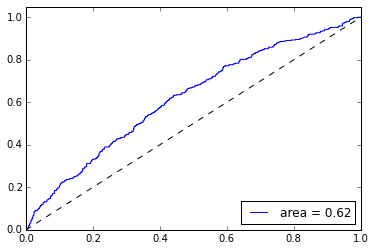

0.619158679504


In [34]:
train_narrative_excl_cap=np.concatenate((train_narrative_excl, train_caps), axis=1)
dev_narrative_excl_cap=np.concatenate((dev_narrative_excl, dev_caps), axis=1)
print(train_narrative_excl_cap.shape)
# train_log(train_matrix_process_text,dev_matrix_process_text)
# train_log(train_narrative,dev_narrative)
np.random.seed(0)

# vectorizer_process = CountVectorizer(analyzer='word',stop_words='english',preprocessor = empty_preprocessor)
# word_matrix_process= vectorizer_process.fit_transform(train_all_balance)
# dev_matrix_process = vectorizer_process.transform(dev_all)

a=train_narrative_excl_cap
b=dev_narrative_excl_cap

model_LG_L1 = LogisticRegression(penalty ='l1',C=1)#C from the above test
model_LG_L1.fit(a, np.ravel(train_labels))

#Update the new index
index=[]
for i,z in enumerate(np.sum(np.abs(model_LG_L1.coef_),axis=0) ):
    if z!=0:
        index.append(i)
            
model_LG = LogisticRegression(penalty ='l2',C=13)#C from the above test
model_LG.fit(a[:,index], np.ravel(train_labels))

preds = model_LG.predict(b[:,index])
F_Score = metrics.f1_score(np.ravel(dev_labels), preds, average='binary')
pred_probas = model_LG.predict_proba(b[:,index])

#Call to display outputs
model_output(pred_probas, F_Score, preds) #Please input pred_probas, F_Score, and prediction(preds)
fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
roc_auc = metrics.auc(fpr,tpr)
print (roc_auc)

(3975, 449)
0.644384159413
Logistic regression on numeric data: F-Score = 0.0393: 
Accuracy = 0.7406
accuracy_score: 0.473684
recall_score: 0.020501
roc_auc_score: 0.506272844735
auc: 0.64


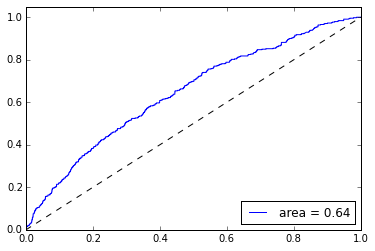

In [73]:
train_narrative_excl_cap=np.concatenate((train_narrative_excl, train_caps), axis=1)
dev_narrative_excl_cap=np.concatenate((dev_narrative_excl, dev_caps), axis=1)
print(train_narrative_excl_cap.shape)
# train_log(train_matrix_process_text,dev_matrix_process_text)
# train_log(train_narrative,dev_narrative)
np.random.seed(0)

# vectorizer_process = CountVectorizer(analyzer='word',stop_words='english',preprocessor = empty_preprocessor)
# word_matrix_process= vectorizer_process.fit_transform(train_all_balance)
# dev_matrix_process = vectorizer_process.transform(dev_all)

a=train_narrative_excl_cap
b=dev_narrative_excl_cap

model_LG_L1 = LogisticRegression(penalty ='l1',C=1)#C from the above test
model_LG_L1.fit(a, np.ravel(train_labels))

#Update the new index
index=[]
for i,z in enumerate(np.sum(np.abs(model_LG_L1.coef_),axis=0) ):
    if z!=0:
        index.append(i)
            
model_LG = LogisticRegression(penalty ='l2',C=0.26)#C from the above test
model_LG.fit(a[:,index], np.ravel(train_labels))

preds = model_LG.predict(b[:,index])
F_Score = metrics.f1_score(np.ravel(dev_labels), preds, average='binary')
pred_probas = model_LG.predict_proba(b[:,index])

#Call to display outputs

fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
roc_auc = metrics.auc(fpr,tpr)
print (roc_auc)
model_output(pred_probas, F_Score, preds) #Please input pred_probas, F_Score, and prediction(preds)


In [38]:
train_narrative_excl_cap=np.concatenate((train_narrative_excl, train_caps), axis=1)
dev_narrative_excl_cap=np.concatenate((dev_narrative_excl, dev_caps), axis=1)
print(train_narrative_excl_cap.shape)
# train_log(train_matrix_process_text,dev_matrix_process_text)
# train_log(train_narrative,dev_narrative)
np.random.seed(0)

# vectorizer_process = CountVectorizer(analyzer='word',stop_words='english',preprocessor = empty_preprocessor)
# word_matrix_process= vectorizer_process.fit_transform(train_all_balance)
# dev_matrix_process = vectorizer_process.transform(dev_all)

a=train_narrative_excl_cap
b=dev_narrative_excl_cap

auc=[]
c1=[]
c2=[]
for i in np.arange(0.1,3,0.1):
    for j in np.arange(0.1,5,0.1):
        
        model_LG_L1 = LogisticRegression(penalty ='l1',C=i)#C from the above test 0.7
        model_LG_L1.fit(a, np.ravel(train_labels))

        #Update the new index
        index=[]
        for i,z in enumerate(np.sum(np.abs(model_LG_L1.coef_),axis=0) ):
            if z!=0:
                index.append(i)

        model_LG = LogisticRegression(penalty ='l2',C=j)#C from the above test 0.3
        model_LG.fit(a[:,index], np.ravel(train_labels))

        preds = model_LG.predict(b[:,index])
        F_Score = metrics.f1_score(np.ravel(dev_labels), preds, average='binary')
        pred_probas = model_LG.predict_proba(b[:,index])

        #Call to display outputs
    #     model_output(pred_probas, F_Score, preds) #Please input pred_probas, F_Score, and prediction(preds)
        fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
        roc_auc = metrics.auc(fpr,tpr)
        auc.append(roc_auc)
        c1.append(i)
        c2.append(j)

(3975, 449)


#PLEASE STOP HERE

###The below code is only an appendix of what I have tested previously

##Title

In [ ]:
def empty_preprocessor(s):
    return s


    
vectorizer_process_title = TfidfVectorizer(preprocessor =first_preprocessor,analyzer='word',stop_words='english' )
train_matrix_process_title= vectorizer_process_title.fit_transform(train_title)
dev_matrix_process_title = vectorizer_process_title.transform(dev_title)


model_LG_title = LogisticRegression(penalty ='l2',C=12)
model_LG_title.fit(train_matrix_process_title, np.ravel(train_labels))

# print('f1_score: %f' %metrics.f1_score(dev_labels,model_LG.predict(dev_matrix_process_text),average='binary'))
# print('precision_score: %f' %metrics.precision_score(dev_labels,model_LG.predict(dev_matrix_process_text)))
# print('recall_score: %f' %metrics.recall_score(dev_labels,model_LG.predict(dev_matrix_process_text)))
# print('accuracy_score: %f' %metrics.accuracy_score(dev_labels,model_LG.predict(dev_matrix_process_text)))

preds = model_LG_title.predict(dev_matrix_process_title)
F_Score = metrics.f1_score(dev_labels, preds, average='binary')
pred_probas = model_LG_title.predict_proba(dev_matrix_process_title)

#Call to display outputs
model_output(pred_probas, F_Score, preds)
fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
roc_auc = metrics.auc(fpr,tpr)




In [199]:
print(model_LG_limit_title.coef_.shape)
# print( abs(model_LG.coef_ [0]))
# print(len(vectorizer_process.vocabulary_))
# print(vectorizer_process.vocabulary_)
index_good=np.argsort((model_LG_limit_title.coef_ [0]))[-200:]
print(type(index_good))
print(index_good.shape)
df = pd.DataFrame({'Feature': np.array(vectorizer_process_title.get_feature_names())[index_good], 'coef': np.array(model_LG_limit_title.coef_ [0])[index_good]})
print(df)

index_bad=np.argsort((model_LG_limit_title.coef_ [0]))[:200]

df = pd.DataFrame({'Feature': np.array(vectorizer_process_title.get_feature_names())[index_bad], 'coef': np.array(model_LG_limit_title.coef_ [0])[index_bad]})
print(df)

(1, 5325)
<class 'numpy.ndarray'>
(200,)
         Feature      coef
0     variations  2.599917
1           woke  2.607606
2          plain  2.609249
3      Shoreline  2.614414
4        suppose  2.616475
5           Laid  2.617343
6      northwest  2.618045
7        Madison  2.621659
8         Paypal  2.625995
9          spend  2.629419
10            15  2.629707
11          Bday  2.631496
12      provider  2.637658
13            Be  2.638079
14        Lonely  2.638260
15          city  2.640188
16         layed  2.645624
17       cooking  2.645841
18           PTO  2.646531
19      northern  2.649818
20        Castle  2.653504
21            26  2.661185
22         Round  2.663817
23       Midland  2.665807
24           Ann  2.667911
25         Arbor  2.667911
26         Porto  2.669798
27      Portugal  2.669798
28        lights  2.677325
29    roundabout  2.678541
..           ...       ...
170           10  3.654849
171        Cloud  3.664586
172          ago  3.705891
173      spoil

In [195]:
i=vectorizer_process_limit_title.vocabulary_['slice']
a=np.array(np.nonzero(train_matrix_process_title[:,i].toarray()))
print(a)
print(np.array(train_title)[a[0]])
print(np.array(train_labels)[a[0]])

[[1322 1696 1788 1975 2266 2394 2449 2693 3169 3273 3478]
 [   0    0    0    0    0    0    0    0    0    0    0]]
[ '[Request] Boise Idaho security guy, sure would like a slice of pepperoni. :)'
 '[REQUEST] Melting in Phoenix,AZ; Could use a slice or two as relief :D '
 "[Request] - It's the last day of finals and I've been up for 3 days. A slice of pizza could be the extra motivation I need to finish this 20 page religion paper. Help a girl out in the Chicago area! "
 '[REQUEST] WA USA, would like a celebratory slice while working on finals.'
 '[Request] UK, Salivating student seeks special slice'
 "[Request] Long time lurker, plenty of sob stories but none that need to be shared. I know it's hard to get a pizza randomly but I can do things that many people might be afraid to do. I'm hoping for a slice."
 '[Request] Will trade professional graphic design for a tasty slice of love :)'
 '[request] Florida, would murder for a slice. '
 '[Request] Syracuse, NY.broke college student dyi

In [202]:
def empty_preprocessor(s):
    return s

def train_tf_idf_title(dicts):
    
    vectorizer_process_limit_title = TfidfVectorizer(preprocessor =empty_preprocessor,analyzer='word',stop_words='english',vocabulary=dicts )
    train_matrix_process_limit_title= vectorizer_process_limit_title.fit_transform(train_title)
    dev_matrix_process_limit_title = vectorizer_process_limit_title.transform(dev_title)


    model_LG_limit_title = LogisticRegression(penalty ='l2',C=12)
    model_LG_limit_title.fit(train_matrix_process_limit_title, np.ravel(train_labels))

    # print('f1_score: %f' %metrics.f1_score(dev_labels,model_LG.predict(dev_matrix_process_text),average='binary'))
    # print('precision_score: %f' %metrics.precision_score(dev_labels,model_LG.predict(dev_matrix_process_text)))
    # print('recall_score: %f' %metrics.recall_score(dev_labels,model_LG.predict(dev_matrix_process_text)))
    # print('accuracy_score: %f' %metrics.accuracy_score(dev_labels,model_LG.predict(dev_matrix_process_text)))

    preds = model_LG_limit_title.predict(dev_matrix_process_limit_title)
    F_Score = metrics.f1_score(dev_labels, preds, average='binary')
    pred_probas = model_LG_limit_title.predict_proba(dev_matrix_process_limit_title)

    #Call to display outputs
#     model_output(pred_probas, F_Score, preds)
    fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
    roc_auc = metrics.auc(fpr,tpr)
    return roc_auc




In [203]:
auc=[]
idx=[]
for i in range(50,1500,20):
    index_good=np.argsort((model_LG_limit_title.coef_ [0]))[-i:]
    index_bad=np.argsort((model_LG_limit_title.coef_ [0]))[:i]
    dicts=[]
    dicts=list(np.array(vectorizer_process_title.get_feature_names())[index_good])+list(np.array(vectorizer_process_title.get_feature_names())[index_bad])
    auc.append(train_tf_idf_title(dicts))
    idx.append(i)


In [ ]:
plt.plot(idx,auc)
# plt.show()
np.argsort(auc)
print(idx[22])
print(auc[22])

##Combine

In [262]:
index_good=np.argsort((model_LG_limit_title.coef_ [0]))[-490:]
index_bad=np.argsort((model_LG_limit_title.coef_ [0]))[:490]
dicts_title=[]
dicts_title=list(np.array(vectorizer_process_title.get_feature_names())[index_good])+list(np.array(vectorizer_process_title.get_feature_names())[index_bad])
index_good=np.argsort((model_LG.coef_ [0]))[-2740:]
index_bad=np.argsort((model_LG.coef_ [0]))[:2740]
dicts_text=[]
dicts_text=list(np.array(vectorizer_process.get_feature_names())[index_good])+list(np.array(vectorizer_process.get_feature_names())[index_bad])



    

In [263]:
vectorizer_process_limit_title = TfidfVectorizer(preprocessor =empty_preprocessor,analyzer='word',stop_words='english',vocabulary=dicts_title )
train_matrix_process_limit_title= vectorizer_process_limit_title.fit_transform(train_title)
dev_matrix_process_limit_title = vectorizer_process_limit_title.transform(dev_title)

vectorizer_process_limit_text = TfidfVectorizer(preprocessor =empty_preprocessor,analyzer='word',stop_words='english',vocabulary=dicts_text )
train_matrix_process_text= vectorizer_process_limit_text.fit_transform(train_text)
dev_matrix_process_text = vectorizer_process_limit_text.transform(dev_text)


In [264]:
print(train_matrix_process_limit_title.shape)
print(dev_matrix_process_limit_title.shape)

print(train_matrix_process_text.shape)
print(dev_matrix_process_text.shape)

train_combine=np.hstack( (train_matrix_process_limit_title.toarray(),train_matrix_process_text.toarray()))
dev_combine=np.hstack( (dev_matrix_process_limit_title.toarray(),dev_matrix_process_text.toarray()))
print(dev_combine.shape)
# print(train_matrix_process_limit_title.toarray())

(3975, 980)
(1696, 980)
(3975, 5480)
(1696, 5480)
(1696, 6460)


Logistic regression on numeric data: F-Score = 0.2906: 
Accuracy = 0.7093
accuracy_score: 0.394531
recall_score: 0.230068
roc_auc_score: 0.553379435072
auc: 0.58


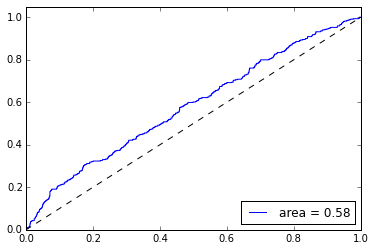

0.581291464836


In [265]:
model_LG_all= LogisticRegression(penalty ='l2',C=12)
model_LG_all.fit(train_combine, np.ravel(train_labels))

# print('f1_score: %f' %metrics.f1_score(dev_labels,model_LG.predict(dev_matrix_process_text),average='binary'))
# print('precision_score: %f' %metrics.precision_score(dev_labels,model_LG.predict(dev_matrix_process_text)))
# print('recall_score: %f' %metrics.recall_score(dev_labels,model_LG.predict(dev_matrix_process_text)))
# print('accuracy_score: %f' %metrics.accuracy_score(dev_labels,model_LG.predict(dev_matrix_process_text)))

preds = model_LG_all.predict(dev_combine)
F_Score = metrics.f1_score(dev_labels, preds, average='binary')
pred_probas = model_LG_all.predict_proba(dev_combine)

#Call to display outputs
model_output(pred_probas, F_Score, preds)
fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
roc_auc = metrics.auc(fpr,tpr)
print (roc_auc)

###narrative

In [272]:

train_all = train_text+train_title
dev_all = dev_text+dev_title

In [266]:
desire = re.compile(r'(friend|party|birthday|boyfriend|girlfriend|date|drinks|drunk|wasted|invite|invited|celebrate|celebrating|game|games|movie|beer|crave|craving)', re.IGNORECASE)
family = re.compile(r'(husband|wife|family|parent|parents|mother|father|mom|mum|son|dad|daughter)', re.IGNORECASE)
job = re.compile(r'(job|unemployment|employment|hire|hired|fired|interview|work|paycheck)', re.IGNORECASE)
money = re.compile(r'(money|bill|bills|rent|bank|account|paycheck|due|broke|bills|deposit|cash|dollar|dollars|bucks|paid|payed|buy|check|spent|financial|poor|loan|\
credit|budget|day|now|time|week|until|last|month|tonight|today|next|night|when|tomorrow|first|after|while|before|long|hour|Friday|ago|still|due|past|soon|current|years|never|till|yesterday|morning|evening)', re.IGNORECASE)
student = re.compile(r'(college|student|university|finals|study|studying|class|semester|school|roommate|project|tuition|dorm)', re.IGNORECASE)
mood = re.compile(r'(thank|nice|like|best|great|surprise)', re.IGNORECASE) 




In [269]:
def myfunc(a,b):
    if len(a)==0:
        return 0 
    else:
        return len(b.findall(a))/float(len(a))



In [273]:
narrative_all=np.ndarray(shape=(len(train_text),5),dtype=int)
narrative_all_dev=np.ndarray(shape=(len(dev_text),5),dtype=int)

for index,i in enumerate([desire,family,job,money,student]):
    
    vfunc = np.vectorize(myfunc)
    narrative=vfunc(train_all,i)
    narrative_dev=vfunc(dev_all,i)
    med=np.median(narrative)
    narrative_all[:,index]=np.where(narrative>med,1,0)
    narrative_all_dev[:,index]=np.where(narrative_dev>med,1,0)
    


In [286]:


# np.hstack((word_matrix_process, narrative_all))
# word_matrix_process+narrative_all
a=np.concatenate((train_matrix_process_text.toarray(), narrative_all), axis=1)
b=np.concatenate((dev_matrix_process_text.toarray(), narrative_all_dev), axis=1)

In [276]:
print(train_matrix_process_text.shape) 
print(dev_matrix_process_text.shape) 
print(a.shape) 
print(b.shape) 

(3975, 5480)
(1696, 5480)
(3975, 5485)
(1696, 5485)


Logistic regression on numeric data: F-Score = 0.0223: 
Accuracy = 0.7417
accuracy_score: 0.555556
recall_score: 0.011390
roc_auc_score: 0.504103670923
auc: 0.63


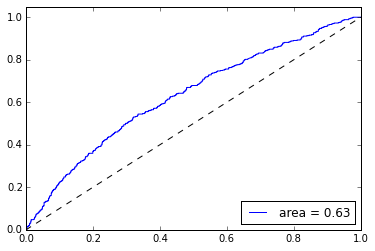

0.630541858531


In [317]:
def empty_preprocessor(s):
    return s


# vectorizer_process = CountVectorizer(preprocessor =empty_preprocessor,analyzer='word',stop_words='english' )
# word_matrix_process= vectorizer_process.fit_transform(train_all_balance)
# dev_matrix_process = vectorizer_process.transform(dev_all)

# a=np.concatenate((word_matrix_process.toarray(), narrative_all), axis=1)
# b=np.concatenate((dev_matrix_process.toarray(), narrative_all_dev), axis=1)

model_LG = LogisticRegression(penalty ='l2',C=0.3)
model_LG.fit(a, np.ravel(train_labels))

preds = model_LG.predict(b)
F_Score = metrics.f1_score(dev_labels, preds, average='binary')
pred_probas = model_LG.predict_proba(b)

#Call to display outputs
model_output(pred_probas, F_Score, preds)
fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
roc_auc = metrics.auc(fpr,tpr)
print (roc_auc)

Logistic regression on numeric data: F-Score = 0.0090: 
Accuracy = 0.7412
accuracy_score: 0.500000
recall_score: 0.004556
roc_auc_score: 0.50148235938
auc: 0.63


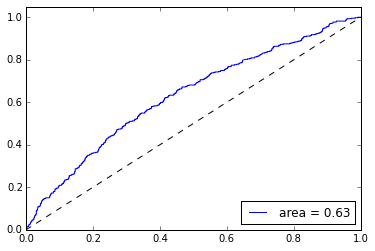

0.630142273881


In [326]:
np.random.seed(0)

# vectorizer_process = CountVectorizer(analyzer='word',stop_words='english',preprocessor = empty_preprocessor)
# word_matrix_process= vectorizer_process.fit_transform(train_all_balance)
# dev_matrix_process = vectorizer_process.transform(dev_all)

# a=np.concatenate((word_matrix_process.toarray(), narrative_all), axis=1)
# b=np.concatenate((dev_matrix_process.toarray(), narrative_all_dev), axis=1)

model_LG_L1 = LogisticRegression(penalty ='l1',C=14)#C from the above test
model_LG_L1.fit(a, np.ravel(train_labels))

#Update the new index
index=[]
for i,z in enumerate(np.sum(np.abs(model_LG_L1.coef_),axis=0) ):
    if z!=0:
        index.append(i)
            
model_LG = LogisticRegression(penalty ='l2',C=0.3)#C from the above test
model_LG.fit(a[:,index], np.ravel(train_labels))

preds = model_LG.predict(b[:,index])
F_Score = metrics.f1_score(np.ravel(dev_labels), preds, average='binary')
pred_probas = model_LG.predict_proba(b[:,index])

#Call to display outputs
model_output(pred_probas, F_Score, preds) #Please input pred_probas, F_Score, and prediction(preds)
fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
roc_auc = metrics.auc(fpr,tpr)
print (roc_auc)